# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle as pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## Feature Estractors
#### Implementacion: Hog

In [15]:
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3
    CNN = 4

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)
	elif method == FeatureExtractors.CNN:
		image_representation = prep_for_cnn(image)
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
    return fd

def prep_for_cnn(img):
    #print(img.shape)
    if len(img.shape)==3 and img.shape[2] == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    return img/255.0

## Data Loader & ShowImg

In [3]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.HOG,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    positive_img_files = positive_img_files[:7500]
    negative_img_files = negative_img_files[:7500]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    validation_annotations= pd.read_pickle(os.path.join(validation_data_dir,'validation_bbox.pickle'))
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes

def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [4]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[0];
    w_cols = window_size[1];
    
    cc = (i_cols - w_cols)//step_size
    cr = (i_rows - w_rows)//step_size
    return cc*cr

def sliding_window(img, window_size, scale, step_size):
    
    scales = [scale, 3*(scale/4), scale/2, scale/4]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
    
    patches = np.zeros((window_size[0], window_size[1], ct))
    bbox_locations = np.zeros((ct, 4))
    
    i=0
    for image in images:
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [y, x, window_size[0], window_size[1]]
                    i+= 1
                except:
                    pass
                    
    return patches, bbox_locations

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [5]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'validation')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [6]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.CNN)

  0%|          | 32/7500 [00:00<00:23, 317.39it/s]

##Loading 7500 positive face images
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


  2%|▏         | 121/7500 [00:00<00:17, 412.50it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  3%|▎         | 225/7500 [00:00<00:15, 475.59it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  4%|▍         | 329/7500 [00:00<00:14, 495.04it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  6%|▌         | 428/7500 [00:00<00:14, 474.45it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  6%|▋         | 477/7500 [00:01<00:14, 477.79it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


  8%|▊         | 578/7500 [00:02<00:38, 180.27it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  9%|▉         | 676/7500 [00:02<00:25, 265.51it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 10%|▉         | 730/7500 [00:02<00:21, 316.54it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 11%|█         | 839/7500 [00:02<00:16, 405.10it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 13%|█▎        | 950/7500 [00:02<00:13, 469.33it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 14%|█▍        | 1058/7500 [00:02<00:12, 500.43it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 16%|█▌        | 1165/7500 [00:03<00:12, 505.95it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 17%|█▋        | 1271/7500 [00:03<00:12, 494.24it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 18%|█▊        | 1325/7500 [00:03<00:12, 505.41it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 19%|█▉        | 1432/7500 [00:03<00:11, 515.77it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 20%|██        | 1535/7500 [00:03<00:11, 505.00it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 22%|██▏       | 1640/7500 [00:04<00:11, 510.91it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 23%|██▎       | 1743/7500 [00:04<00:11, 502.69it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 24%|██▍       | 1798/7500 [00:04<00:11, 513.85it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 25%|██▌       | 1901/7500 [00:04<00:11, 502.20it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 27%|██▋       | 2007/7500 [00:04<00:11, 497.68it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 28%|██▊       | 2109/7500 [00:05<00:10, 499.38it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 29%|██▉       | 2208/7500 [00:05<00:11, 478.23it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 30%|███       | 2257/7500 [00:05<00:10, 481.47it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 31%|███▏      | 2361/7500 [00:05<00:10, 496.31it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 33%|███▎      | 2466/7500 [00:05<00:09, 508.23it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 34%|███▍      | 2567/7500 [00:05<00:10, 486.82it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 36%|███▌      | 2664/7500 [00:06<00:10, 471.18it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 36%|███▌      | 2712/7500 [00:06<00:10, 472.24it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 38%|███▊      | 2819/7500 [00:06<00:09, 501.80it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 39%|███▉      | 2929/7500 [00:06<00:08, 524.58it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 41%|████      | 3038/7500 [00:06<00:08, 525.50it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 42%|████▏     | 3147/7500 [00:07<00:08, 531.61it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 43%|████▎     | 3254/7500 [00:07<00:08, 520.47it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 44%|████▍     | 3307/7500 [00:07<00:08, 517.62it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 46%|████▌     | 3414/7500 [00:07<00:07, 519.48it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 47%|████▋     | 3514/7500 [00:07<00:08, 445.58it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 47%|████▋     | 3560/7500 [00:08<00:09, 436.19it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 49%|████▉     | 3660/7500 [00:08<00:08, 466.85it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 50%|█████     | 3757/7500 [00:08<00:08, 467.70it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 51%|█████▏    | 3853/7500 [00:08<00:07, 471.24it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 53%|█████▎    | 3952/7500 [00:08<00:07, 480.37it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 53%|█████▎    | 4001/7500 [00:08<00:07, 476.05it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 55%|█████▍    | 4101/7500 [00:09<00:06, 485.88it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 56%|█████▌    | 4200/7500 [00:09<00:06, 489.11it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 57%|█████▋    | 4298/7500 [00:09<00:06, 485.60it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 59%|█████▊    | 4398/7500 [00:09<00:06, 491.28it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 60%|██████    | 4501/7500 [00:09<00:05, 502.64it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 61%|██████▏   | 4604/7500 [00:10<00:05, 501.23it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 62%|██████▏   | 4655/7500 [00:10<00:05, 497.79it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 63%|██████▎   | 4756/7500 [00:10<00:05, 484.86it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 65%|██████▍   | 4860/7500 [00:10<00:05, 494.75it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 66%|██████▌   | 4964/7500 [00:10<00:05, 491.30it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 67%|██████▋   | 5014/7500 [00:10<00:05, 484.18it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 68%|██████▊   | 5117/7500 [00:11<00:04, 491.25it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 70%|██████▉   | 5218/7500 [00:11<00:04, 493.48it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 71%|███████   | 5321/7500 [00:11<00:04, 503.99it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 72%|███████▏  | 5430/7500 [00:11<00:03, 521.69it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 74%|███████▍  | 5534/7500 [00:12<00:03, 505.14it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 75%|███████▍  | 5590/7500 [00:12<00:03, 520.90it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 76%|███████▌  | 5702/7500 [00:12<00:03, 535.43it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 77%|███████▋  | 5811/7500 [00:12<00:03, 530.85it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 79%|███████▉  | 5920/7500 [00:12<00:02, 533.41it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 80%|████████  | 6028/7500 [00:12<00:02, 528.03it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 82%|████████▏ | 6134/7500 [00:13<00:02, 527.21it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 83%|████████▎ | 6189/7500 [00:13<00:02, 533.83it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 84%|████████▍ | 6296/7500 [00:13<00:02, 522.97it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 85%|████████▌ | 6407/7500 [00:13<00:02, 537.44it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 87%|████████▋ | 6517/7500 [00:13<00:01, 537.40it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 88%|████████▊ | 6626/7500 [00:14<00:01, 536.72it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 90%|████████▉ | 6738/7500 [00:14<00:01, 546.94it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 91%|█████████▏| 6850/7500 [00:14<00:01, 551.56it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 92%|█████████▏| 6906/7500 [00:14<00:01, 542.18it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 94%|█████████▎| 7016/7500 [00:14<00:00, 533.92it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 95%|█████████▌| 7129/7500 [00:14<00:00, 546.11it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 97%|█████████▋| 7239/7500 [00:15<00:00, 544.92it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 98%|█████████▊| 7353/7500 [00:15<00:00, 556.23it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

100%|█████████▉| 7467/7500 [00:15<00:00, 558.90it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  1%|          | 58/7489 [00:00<00:13, 568.82it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
##Loading 7489 negative face images
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3

  2%|▏         | 172/7489 [00:00<00:13, 549.00it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  3%|▎         | 231/7489 [00:00<00:12, 564.75it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  5%|▍         | 349/7489 [00:00<00:12, 576.62it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  6%|▌         | 465/7489 [00:00<00:12, 575.95it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  8%|▊         | 583/7489 [00:01<00:11, 578.28it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

  9%|▉         | 703/7489 [00:01<00:11, 587.19it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 11%|█         | 822/7489 [00:01<00:11, 581.17it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 12%|█▏        | 881/7489 [00:01<00:11, 581.40it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 13%|█▎        | 1000/7489 [00:01<00:11, 583.76it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 15%|█▍        | 1118/7489 [00:01<00:10, 579.62it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 16%|█▋        | 1235/7489 [00:02<00:29, 214.10it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 18%|█▊        | 1352/7489 [00:03<00:19, 314.87it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 20%|█▉        | 1468/7489 [00:03<00:14, 409.81it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 21%|██        | 1582/7489 [00:03<00:12, 476.71it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 22%|██▏       | 1641/7489 [00:03<00:11, 504.21it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 23%|██▎       | 1756/7489 [00:03<00:10, 535.34it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 25%|██▍       | 1870/7489 [00:04<00:10, 542.69it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 26%|██▋       | 1983/7489 [00:04<00:10, 548.45it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 28%|██▊       | 2098/7489 [00:04<00:09, 560.18it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 30%|██▉       | 2214/7489 [00:04<00:09, 569.63it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 31%|███       | 2330/7489 [00:04<00:09, 570.16it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 32%|███▏      | 2388/7489 [00:04<00:08, 567.39it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 33%|███▎      | 2506/7489 [00:05<00:08, 575.85it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 35%|███▌      | 2625/7489 [00:05<00:08, 578.72it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 37%|███▋      | 2741/7489 [00:05<00:08, 571.99it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 38%|███▊      | 2857/7489 [00:05<00:08, 572.43it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 40%|███▉      | 2973/7489 [00:06<00:07, 572.57it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 40%|████      | 3032/7489 [00:06<00:07, 574.84it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 42%|████▏     | 3148/7489 [00:06<00:07, 569.26it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 44%|████▎     | 3263/7489 [00:06<00:07, 569.00it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 45%|████▌     | 3380/7489 [00:06<00:07, 572.82it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 47%|████▋     | 3497/7489 [00:06<00:06, 573.11it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 48%|████▊     | 3613/7489 [00:07<00:06, 574.36it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 50%|████▉     | 3732/7489 [00:07<00:06, 581.67it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 51%|█████     | 3791/7489 [00:07<00:06, 579.30it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 52%|█████▏    | 3907/7489 [00:07<00:06, 572.28it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 54%|█████▎    | 4023/7489 [00:07<00:06, 574.64it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 55%|█████▌    | 4140/7489 [00:08<00:05, 575.81it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 57%|█████▋    | 4258/7489 [00:08<00:05, 579.87it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 58%|█████▊    | 4377/7489 [00:08<00:05, 581.07it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 59%|█████▉    | 4436/7489 [00:08<00:05, 577.55it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 61%|██████    | 4553/7489 [00:08<00:05, 577.10it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 62%|██████▏   | 4669/7489 [00:08<00:04, 573.46it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 64%|██████▍   | 4787/7489 [00:09<00:04, 574.89it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 65%|██████▌   | 4903/7489 [00:09<00:04, 570.75it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 67%|██████▋   | 5019/7489 [00:09<00:04, 571.25it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 68%|██████▊   | 5078/7489 [00:09<00:04, 573.87it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 69%|██████▉   | 5195/7489 [00:09<00:03, 573.59it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 71%|███████   | 5313/7489 [00:10<00:03, 579.24it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 72%|███████▏  | 5429/7489 [00:10<00:03, 576.85it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 74%|███████▍  | 5545/7489 [00:10<00:03, 570.36it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 76%|███████▌  | 5663/7489 [00:10<00:03, 577.79it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 77%|███████▋  | 5782/7489 [00:10<00:02, 580.77it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 78%|███████▊  | 5841/7489 [00:10<00:02, 579.99it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 80%|███████▉  | 5958/7489 [00:11<00:02, 575.90it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 81%|████████  | 6074/7489 [00:11<00:02, 573.10it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 83%|████████▎ | 6191/7489 [00:11<00:02, 578.59it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 84%|████████▍ | 6310/7489 [00:11<00:02, 581.69it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 86%|████████▌ | 6428/7489 [00:12<00:01, 582.09it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 87%|████████▋ | 6488/7489 [00:12<00:01, 585.68it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 88%|████████▊ | 6606/7489 [00:12<00:01, 573.55it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 90%|████████▉ | 6722/7489 [00:12<00:01, 572.52it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 91%|█████████▏| 6840/7489 [00:12<00:01, 574.92it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 93%|█████████▎| 6957/7489 [00:12<00:00, 573.92it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 94%|█████████▍| 7074/7489 [00:13<00:00, 569.21it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 95%|█████████▌| 7131/7489 [00:13<00:00, 562.66it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 97%|█████████▋| 7245/7489 [00:13<00:00, 559.92it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

 98%|█████████▊| 7358/7489 [00:13<00:00, 557.16it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

100%|██████████| 7489/7489 [00:13<00:00, 539.39it/s]

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 

#### Load Validation Data

In [7]:
validation_data = load_validation_data(validation_faces_dir)

 16%|█▌        | 28/175 [00:00<00:00, 276.98it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 327.01it/s]


#### Entrenar el clasificador SVM de sklearn

In [ ]:
svm_classifier = svm.SVC(kernel='linear',
                         probability=True)

In [ ]:
svm_classifier.fit(training_data, training_labels)

## Keras CNN

In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(128, 128, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 61, 61, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                    

In [31]:
model.fit(training_data, training_labels, epochs=89)

Epoch 1/89
469/469 [==============================] - 87s 185ms/step - loss: 0.0252 - accuracy: 0.9927
Epoch 2/89
469/469 [==============================] - 88s 189ms/step - loss: 0.0220 - accuracy: 0.9939
Epoch 3/89
469/469 [==============================] - 87s 185ms/step - loss: 0.0221 - accuracy: 0.9945
Epoch 4/89
469/469 [==============================] - 88s 189ms/step - loss: 0.0185 - accuracy: 0.9945
Epoch 5/89
469/469 [==============================] - 90s 193ms/step - loss: 0.0217 - accuracy: 0.9944
Epoch 6/89
469/469 [==============================] - 87s 186ms/step - loss: 0.0207 - accuracy: 0.9949
Epoch 7/89
469/469 [==============================] - 83s 177ms/step - loss: 0.0195 - accuracy: 0.9937
Epoch 8/89
469/469 [==============================] - 83s 177ms/step - loss: 0.0195 - accuracy: 0.9951
Epoch 9/89
469/469 [==============================] - 86s 184ms/step - loss: 0.0198 - accuracy: 0.9947
Epoch 10/89
469/469 [==============================] - 83s 176ms/step - l

469/469 [==============================] - 83s 178ms/step - loss: 0.0067 - accuracy: 0.9993
Epoch 80/89
469/469 [==============================] - 83s 176ms/step - loss: 0.0149 - accuracy: 0.9986
Epoch 81/89
469/469 [==============================] - 82s 174ms/step - loss: 0.0048 - accuracy: 0.9993
Epoch 82/89
469/469 [==============================] - 81s 173ms/step - loss: 0.0044 - accuracy: 0.9996
Epoch 83/89
469/469 [==============================] - 82s 176ms/step - loss: 0.0041 - accuracy: 0.9993
Epoch 84/89
469/469 [==============================] - 83s 177ms/step - loss: 0.0053 - accuracy: 0.9992
Epoch 85/89
469/469 [==============================] - 81s 172ms/step - loss: 0.0084 - accuracy: 0.9993
Epoch 86/89
469/469 [==============================] - 81s 173ms/step - loss: 0.0040 - accuracy: 0.9995
Epoch 87/89
469/469 [==============================] - 82s 176ms/step - loss: 0.0042 - accuracy: 0.9994
Epoch 88/89
469/469 [==============================] - 82s 174ms/step - loss

#### Save trained model

In [ ]:
#svm
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

In [32]:
#cnn
model.save('face_detector.h5')

#### Load trained model

In [ ]:
# svm
classifier = pickle.load(open('./face_detector','rb'))

In [33]:
#cnn
classifier = keras.models.load_model('face_detector.h5')

## Sliding Window & Results

 18%|█▊        | 32/175 [00:00<00:00, 319.71it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 364.09it/s]


2/2 [==============================] - 0s 32ms/step


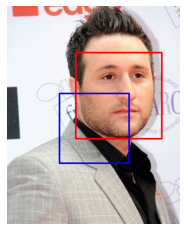

2/2 [==============================] - 0s 18ms/step


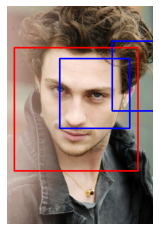

3/3 [==============================] - 0s 31ms/step


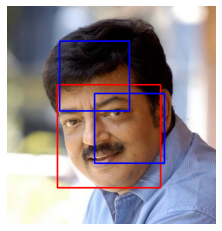

1/1 [==============================] - 0s 28ms/step


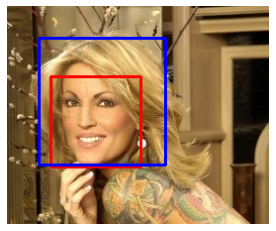

3/3 [==============================] - 0s 38ms/step


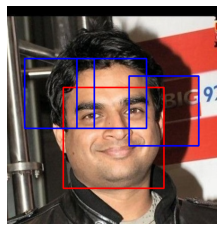

2/2 [==============================] - 0s 18ms/step


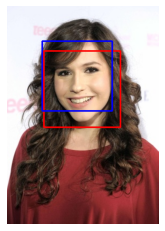

2/2 [==============================] - 0s 32ms/step


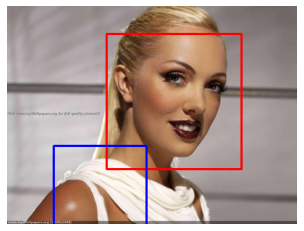

2/2 [==============================] - 0s 17ms/step


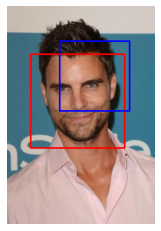

2/2 [==============================] - 0s 17ms/step


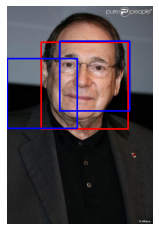

2/2 [==============================] - 0s 27ms/step


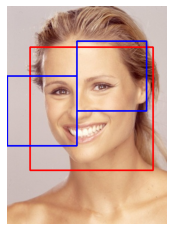

3/3 [==============================] - 0s 29ms/step


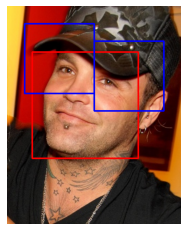

2/2 [==============================] - 0s 19ms/step


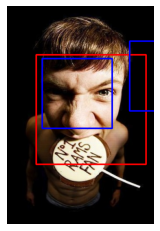

3/3 [==============================] - 0s 34ms/step


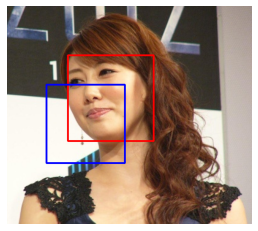

2/2 [==============================] - 0s 28ms/step


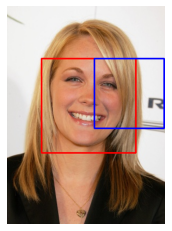

3/3 [==============================] - 0s 32ms/step


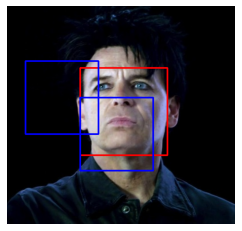

3/3 [==============================] - 0s 33ms/step


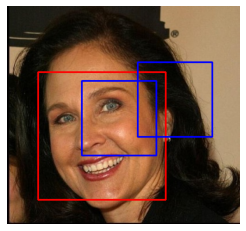

2/2 [==============================] - 0s 16ms/step


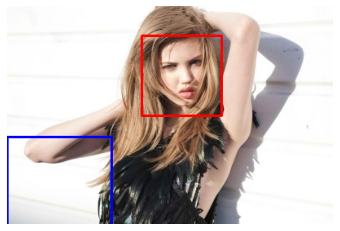

2/2 [==============================] - 0s 25ms/step


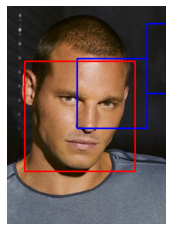

2/2 [==============================] - 0s 17ms/step


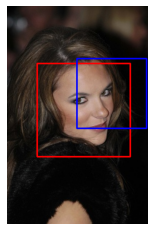

2/2 [==============================] - 0s 17ms/step


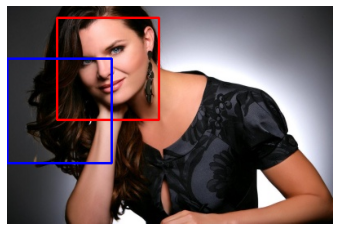

In [34]:
'''
Afinar parametros:
    threshold_p
    overlap_threshold
    non_max_threshold
'''

non_max_threshold = 0.3
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 20
stride = 32
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict(patches_feature_representation)
        face_probabilities = scores[:,0]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,non_max_threshold)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox,gt_bbox)

## Evaluate Detector

In [35]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.CNN, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict(patches_feature_representation)
    
    print(scores)
    ## Positive Face Probabilities
    face_probabilities = scores[:,0]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

 22%|██▏       | 38/175 [00:00<00:00, 370.00it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 373.11it/s]


34/34 [==============================] - 2s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.87845939e-29]
 [2.21262984e-15]
 [5.18889106e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.52539059e-20]
 [7.20212704e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

48/48 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
7/7 [==============================] - 0s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [6.03132384e-30]
 [7.32781078e-14]
 [3.39974522e-13]
 [5.93147973e-22]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.24493383e-29]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.48630922e-33]
 [1.00000000e+00]
 [2.00372353e-01]
 [1.66781815e-38]
 [2.63478218e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.77545550e-18]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.38315624e-29]
 [0.00000000e+00]
 [9.99985635e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.34270657e-15]
 [5.80878950e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00

31/31 [==============================] - 1s 40ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.3508053e-25]
 [4.2921819e-14]
 [9.9996412e-01]
 [1.4801746e-12]
 [1.1745246e-27]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000

24/24 [==============================] - 1s 41ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 40ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.29430215e-32]
 [7.08301226e-03]
 [5.94925567e-11]
 [2.35232937e-06]
 [1.00000000e+00]
 [9.96798873e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.06560505e-20]
 [1.02305379e-24]
 [6.66800761e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.09449416e-18]
 [0.00000000e+00]
 [0.000000

30/30 [==============================] - 1s 39ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.12556863e-33]
 [2.55044353e-31]
 [3.60129203e-36]
 [3.31892381e-33]
 [1.04301630e-10]
 [6.94643736e-01]
 [9.90594864e-01]
 [1.12419129e-18]
 [4.32233820e-19]
 [1.57267125e-12]
 [1.97945162e-14]
 [1.26295480e-33]
 [1.67269114e-32]
 [5.19160864e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.27790786e-37]
 [6.26564656e-25]
 [2.71621573e-25]
 [6.32591132e-11]
 [9.99493837e-01]
 [2.23011142e-07]
 [6.37728529e-20]
 [4.80547575e-14]
 [1.90178335e-22]
 [8.89494648e-20]
 [3.33806704e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

36/36 [==============================] - 2s 58ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 51ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

43/43 [==============================] - 2s 47ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
30/30 [==============================] - 1s 48ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.55167315e-31]
 [7.55276614e-18]
 [7.96855576e-17]
 [5.63923557e-21]
 [4.24182488e-27]
 [1.58020495e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.55385353e-29]
 [1.12072014e-08]
 [9.53929884e-07]
 [2.47554723e-02]
 [1.68492515e-02]
 [1.00000000e+00]
 [8.47993759e-11]
 [2.35678531e-25]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

48/48 [==============================] - 2s 46ms/step
[[3.4017778e-27]
 [1.3491949e-28]
 [2.6777051e-27]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
47/47 [==============================] - 2s 47ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.5233446e-33]
 [8.4293228e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [7.5415765e-23]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.6760373e-37]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000

30/30 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.79179725e-34]
 [4.25731696e-22]
 [6.07238147e-19]
 [1.13896631e-19]
 [7.99975591e-14]
 [4.11148710e-21]
 [9.33445600e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.47533719e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.21162283e-35]
 [1.81974591e-24]
 [9.18262212e-28]
 [4.04902745e-28]
 [9.24216087e-34]
 [6.36072402e-25]
 [6.89225693e-27]
 [2.20891968e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.55933366e-32]
 [3.49805603e-04]
 [4.29615721e-09]
 [2.04060984e-16]
 [3.38377297e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.30097950e-32]
 [2.34621899e-32]
 [0.000000

23/23 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.94602279e-37]
 [1.49131983e-31]
 [1.33666756e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.66099861e-38]
 [7.22985734e-35]
 [2.07102968e-31]
 [9.33927911e-32]
 [5.25612619e-28]
 [2.31928973e-26]
 [4.13132175e-24]
 [3.01136986e-28]
 [1.91387212e-29]
 [2.98732383e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.64720758e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.04629313e-36]
 [5.87742173e-30]
 [2.68353378e-27]
 [1.99916627e-22]
 [2.76583153e-23]
 [1.15283825e-23]
 [4.20666287e-20]
 [8.08011671e-20]
 [3.35530903e-24]
 [6.73606046e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.10369966e-32]
 [2.086613

24/24 [==============================] - 1s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0978017e-18]
 [9.9991256e-01]
 [1.0000000e+00]
 [4.5241729e-13]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.2525478e-32]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000

33/33 [==============================] - 2s 49ms/step
[[6.614905e-20]
 [0.000000e+00]
 [0.000000e+00]
 ...
 [0.000000e+00]
 [0.000000e+00]
 [0.000000e+00]]
24/24 [==============================] - 1s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [5.2207405e-34]
 [3.3617266e-32]
 [2.6720992e-30]
 [1.8109435e-25]
 [2.9889530e-26]
 [5.0948035e-27]
 [1.0271062e-29]
 [1.6555211e-38]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.3007610e-31]
 [6.6946654e-28]
 [7.1893835e-25]
 [5.0013489e-21]
 [6.8915383e-22]
 [1.2966549e-24]
 [4.6167865e-27]
 [3.0424411e-36]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [4.7191471e-30]
 [7.4612141e-26]
 [2.0218159e-20]
 [1.0496188e-16]
 [5.8468403e-19]
 [2.3226845e-23]
 [1.3695606e-25]
 [8.8278737e-29]
 [7.6241

33/33 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
46/46 [==============================] - 2s 46ms/step
[[0.000000e+00]
 [0.000000e+00]
 [0.000000e+00]
 ...
 [8.934623e-37]
 [0.000000e+00]
 [0.000000e+00]]
23/23 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.98427510e-22]
 [9.98678684e-01]
 [1.00000000e+00]
 [8.04211318e-01]
 [2.53050847e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.15416749e-36]
 [6.12801585e-13]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99972880e-01]
 [3.09768897e-02]
 [2.16201256e-27]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.51123294e-35]
 [9.308214

31/31 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.47768328e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.41025056e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.43330883e-37]
 [4.13549207e-28]
 [5.16593186e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [3.06050723e-36]
 [3.92689992e-32]
 [5.10777806e-29]
 [1.49004002e-24]
 [1.92517639e-23]
 [2.02891511e-21]
 [5.04777264e-13]
 [1.34769644e-08]
 [5.20250050e-15]
 [2.19743528e-18]
 [1.12698108e-20]
 [3.09977054e-16]
 [2.78733066e-17]
 [2.34833627e-21]
 [6.27651456e-15]
 [5.01083423e-06]
 [4.82296497e-19]
 [0.00000000e+00]
 [2.55885254e-32]
 [1.02342977e-29]
 [5.33078754e-32]
 [1.96984211e-27]
 [1.61220024e-23]
 [2.83912273e-15]
 [1.18918005e-14]
 [1.34654056e-15]
 [3.12110267e-17]
 [3.21936316e-19]
 [6.53750817e-22]
 [5.89256866e-17]
 [3.21070611e-01]
 [9.99988019e-01]
 [9.30646837e-10]
 [1.46137973e-19]
 [1.44115103e-19]
 [0.00000000e+00]
 [1.43919305e-37]
 [1.89774324e-33]
 [1.00673434e-34]
 [7.97497274e-32]
 [3.12347232e-25]
 [2.17786423e-12]
 [4.65652994e-12]
 [6.22750462e-11]
 [6.79043070e-18]
 [1.75516982e-21]
 [1.85998965e-23]
 [4.68400914e-24]
 [5.13176697e-12]
 [1.98591079e-05]
 [1.36304732e-15]
 [4.355454

36/36 [==============================] - 2s 45ms/step
[[1.2997764e-14]
 [2.1564628e-18]
 [4.5692566e-14]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
12/12 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.75983143e-26]
 [1.56168032e-23]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+00]
 [6.93412840e-01]
 [8.98825476e-08]
 [1.33932691e-16]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.18101329e-10]
 [1.00000000e+00]
 [1.000000

46/46 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
33/33 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [9.9185896e-30]]
33/33 [==============================] - 2s 48ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 50ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.20980839e-19]
 [2.18880490e-30]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.86180646e-33]
 [1.56609576e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00

23/23 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.26110302e-23]
 [1.88672527e-21]
 [1.47977894e-20]
 [5.02520411e-18]
 [7.78614437e-14]
 [6.53787463e-13]
 [1.12358823e-23]
 [1.17507139e-27]
 [1.09252220e-31]
 [1.52972388e-37]
 [1.78674312e-38]
 [1.49013881e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.57195106e-35]
 [8.62132759e-31]
 [4.73306288e-16]
 [2.53190962e-03]
 [3.61050106e-10]
 [9.34819244e-09]
 [2.30417605e-02]
 [6.44393740e-12]
 [3.19005854e-20]
 [2.81359200e-30]
 [6.22349872e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.69279935e-09]
 [8.24267836e-15]
 [7.50276104e-06]
 [1.00000000e+00]
 [6.91468138e-23]
 [6.25055088e-20]
 [8.80157831e-14]
 [1.47787000e-08]
 [8.02646811e-15]
 [9.10597478e-23]
 [1.12776665e-30]
 [3.14851983e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

41/41 [==============================] - 2s 46ms/step
[[9.9310360e-13]
 [2.4242703e-11]
 [9.4602013e-14]
 ...
 [2.3677285e-22]
 [0.0000000e+00]
 [0.0000000e+00]]
36/36 [==============================] - 2s 45ms/step
[[3.5481301e-33]
 [3.0052687e-33]
 [1.7346852e-32]
 ...
 [8.0655361e-16]
 [0.0000000e+00]
 [0.0000000e+00]]
39/39 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
34/34 [==============================] - 2s 46ms/step
[[1.1290718e-36]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
10/10 [==============================] - 0s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.7983677e-38]
 [7.1457546e-15]
 [8.5657303e-16]
 [1.0527188e-08]
 [2.7759526e-34]
 [2.3725827e-38]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.000

24/24 [==============================] - 1s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.1704352e-28]
 [1.6632758e-30]
 [1.3098578e-26]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.6933404e-37]
 [1.4056239e-29]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.3542115e-29]
 [4.0701947e-29]
 [0.0000000e+00]
 [0.0000000

19/19 [==============================] - 1s 43ms/step
[[1.30681000e-31]
 [7.36941688e-35]
 [4.84416688e-35]
 [8.56323011e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.04073229e-30]
 [0.00000000e+00]
 [3.03770568e-31]
 [1.30446384e-24]
 [6.05978082e-23]
 [7.08588823e-26]
 [4.19321880e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.52499806e-20]
 [2.60565610e-28]
 [1.64660935e-30]
 [2.03205981e-36]
 [7.38441189e-36]
 [1.57479435e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.46072298e-38]
 [2.80151403e-28]
 [0.00000000e+00]
 [1.35354490e-37]
 [2.15729867e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.18036736e-32]
 [0.00000000e+00]
 [7.92015045e-19]
 [6.04948137e-30]
 [6.98488448e-30]
 [6.49726676e-34]
 [2.80401945e-33]
 [5.70058630e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.57742933e-35]
 [9.57473455e-24]
 [1.53988928e-20]
 [1.98382195e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

34/34 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
52/52 [==============================] - 2s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
36/36 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
34/34 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
23/23 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.60485007e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.26108988e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.87933596e-38]
 [0.00000000e+00]
 [2.86409936e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

36/36 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [5.2212874e-38]]
10/10 [==============================] - 0s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.7585932e-08]
 [5.4544005e-11]
 [0.0000000e+00]
 [5.6771388e-28]
 [9.9369621e-01]
 [1.0000000e+00]
 [2.0163031e-33]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.9999911e-01]
 [1.0000000e+00]
 [8.5130250e-01]
 [2.5248870e-09]
 [0.0000000e+00]
 [1.2043065e-18]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.8045008e-13]
 [9.9999046e-01]
 [7.0236711e-14]
 [

46/46 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
26/26 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.71313856e-15]
 [9.99510705e-01]
 [9.99999940e-01]
 [1.00000000e+00]
 [5.07131297e-08]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.46475971e-12]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [5.93385416e-15]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.99838855e-30]
 [1.29443074e-13]
 [9.

45/45 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [1.7747215e-36]
 [6.9334543e-25]]
38/38 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
26/26 [==============================] - 1s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [2.7997264e-23]
 [1.2965816e-15]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.5341508e-18]
 [3.7186044e-27]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.4085933e-24]
 [2.4516557e-36]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [3.8108516e-37]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.2638551e-27]
 [0.0000

41/41 [==============================] - 2s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [1.1026463e-31]
 [5.0696430e-33]
 [1.0453194e-31]]
24/24 [==============================] - 1s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.8808072e-33]
 [9.9973601e-01]
 [1.0000000e+00]
 [9.9961883e-01]
 [1.0000000e+00]
 [2.5886382e-06]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.2272266e-01]
 [9.9903488e-01]
 [5.7391164e-18]
 [1.5277726e-34]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.7498797e-23]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.2002879e-12]
 [

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.43151439e-30]
 [3.74240628e-15]
 [2.99421252e-12]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.32196937e-18]
 [8.06747301e-24]
 [2.10884261e-23]
 [6.82793126e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.21696745e-29]
 [4.87996174e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.22856812e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.29577199e-11]
 [3.08317449e-18]
 [2.78918288e-16]
 [5.89303074e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.32334315e-37]
 [1.55854391e-38]
 [1.41340063e-34]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [5.32145657e-19]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.85597598e-33]
 [1.00000000e+00]
 [1.00000000e+00]
 [8.92781918e-06]
 [5.45560724e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

36/36 [==============================] - 2s 46ms/step
[[7.7614263e-33]
 [3.6045825e-33]
 [9.5776689e-29]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [3.8468305e-27]]
24/24 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.83965960e-28]
 [2.35983925e-29]
 [0.00000000e+00]
 [5.99886034e-36]
 [6.97107118e-22]
 [3.69625114e-16]
 [3.87538801e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.42748096e-37]
 [2.76206385e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.14126774e-30]
 [1.06372210e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.95431854e-28]
 [2.80436255e-25]
 [1.88809576e-11]
 [9.99975443e-01]
 [1.682754

31/31 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.25749399e-32]
 [1.09947399e-18]
 [5.48610257e-13]
 [1.87166898e-16]
 [1.21729580e-16]
 [1.88775332e-15]
 [5.34548046e-13]
 [3.59974828e-09]
 [2.18165295e-11]
 [1.73149879e-13]
 [3.62720394e-18]
 [1.52994637e-21]
 [8.94923870e-26]
 [6.36865505e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.79556048e-33]
 [1.82179858e-20]
 [1.20986097e-16]
 [4.05197945e-20]
 [2.84520889e-20]
 [2.60457243e-21]
 [9.39627716e-13]
 [7.65392959e-01]
 [7.58897632e-12]
 [3.89305091e-20]
 [6.01624533e-24]
 [2.01734686e-28]
 [1.18773893e-28]
 [7.77406703e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.95140566e-30]
 [2.55931504e-29]
 [1.648502

23/23 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.33581121e-31]
 [2.52305193e-21]
 [1.15365565e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.19955206e-36]
 [8.00029397e-01]
 [9.99999821e-01]
 [2.57959869e-06]
 [2.98256064e-09]
 [1.77907405e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.71785895e-16]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [6.32529182e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

38/38 [==============================] - 2s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
30/30 [==============================] - 1s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.0775926e-28]
 [1.5021971e-23]
 [9.3600147e-29]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.8758341e-36]
 [2.9782722e-29]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]


24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.09233951e-26]
 [0.00000000e+00]
 [1.56956989e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.21570022e-03]
 [1.58305971e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.59662857e-33]
 [3.43350284e-16]
 [5.643014

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.27420368e-29]
 [3.20867383e-33]
 [5.08639254e-28]
 [4.46437551e-20]
 [4.64902961e-09]
 [2.16997159e-05]
 [5.62296509e-06]
 [9.32176863e-06]
 [2.94131581e-12]
 [3.17761432e-17]
 [8.21319573e-25]
 [5.13282093e-28]
 [6.54962447e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.43485205e-30]
 [3.60710073e-10]
 [1.83495593e-13]
 [5.86590158e-06]
 [9.99884605e-01]
 [8.96178246e-01]
 [5.17308653e-25]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.70472033e-35]
 [1.00000000e+00]
 [9.99999166e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [7.40152107e-16]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000

33/33 [==============================] - 1s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
39/39 [==============================] - 2s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [8.4420529e-28]
 [1.1510878e-18]
 [0.0000000e+00]]
24/24 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.35457934e-31]
 [0.00000000e+00]
 [2.10350190e-36]
 [6.67034245e-14]
 [1.66122770e-15]
 [7.76490115e-23]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.74873304e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.65757655e-09]
 [1.00000000e+00]
 [9.99782562e-01]
 [6.74570692e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

21/21 [==============================] - 1s 45ms/step
[[1.54679441e-36]
 [4.51871548e-31]
 [1.37513702e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.82250334e-32]
 [4.17556870e-19]
 [1.02440367e-19]
 [3.15342072e-36]
 [0.00000000e+00]
 [9.08756591e-34]
 [1.37280402e-32]
 [9.66365141e-30]
 [4.41984960e-25]
 [7.83360329e-29]
 [3.31384585e-36]
 [0.00000000e+00]
 [1.13834478e-27]
 [1.00488530e-26]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.70518529e-31]
 [4.50162099e-28]
 [5.42685500e-24]
 [1.89836212e-37]
 [0.00000000e+00]
 [1.27464162e-36]
 [1.69681919e-37]
 [2.44077270e-38]
 [6.29051490e-37]
 [9.47723630e-32]
 [3.51889895e-30]
 [0.00000000e+00]
 [5.68914063e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.07702445e-21]
 [2.53648708e-12]
 [1.55937804e-10]
 [1.26572398e-17]
 [2.93072837e-33]
 [3.38758387e-35]
 [3.12906055e-28]
 [1.67866531e-20]
 [2.49850335e-29]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.29815773e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.227437

33/33 [==============================] - 1s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [1.4283506e-10]]
47/47 [==============================] - 2s 43ms/step
[[4.4039807e-09]
 [3.0682193e-23]
 [1.8292258e-31]
 ...
 [0.0000000e+00]
 [8.0645128e-33]
 [0.0000000e+00]]
33/33 [==============================] - 1s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
17/17 [==============================] - 1s 42ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [7.8302572e-14]
 [1.2300579e-16]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.0813011e-28]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]

28/28 [==============================] - 1s 42ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.43786560e-37]
 [2.26317713e-28]
 [7.37897020e-23]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.77371544e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.11340756e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.62277487e-35]
 [0.00000000e+00]
 [1.14310458e-36]
 [1.08939074e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.43196043e-37]
 [0.00000000e+00]
 [1.036025

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.22030902e-34]
 [8.12828487e-27]
 [7.90080558e-27]
 [5.18416045e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.05126184e-04]
 [4.97373202e-25]
 [1.42250627e-31]
 [1.10966801e-06]
 [1.00000000e+00]
 [1.00000000e+00]
 [8.89958290e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 46ms/step
[[9.99972701e-01]
 [9.38025177e-01]
 [1.34168880e-13]
 [1.42773896e-27]
 [1.11291246e-13]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99473155e-01]
 [8.25356332e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.59509453e-09]
 [1.57839043e-30]
 [0.00000000e+00]
 [8.73331058e-23]
 [4.98691782e-32]
 [1.58836859e-30]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.26419601e-07]
 [4.31044962e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.00460325e-26]
 [5.00212600e-08]
 [9.99997437e-01]
 [2.54521519e-03]
 [9.99998152e-01]
 [5.47334564e-15]
 [0.00000000e+00]
 [7.77537993e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.78060112e-25]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.26086705e-12]
 [7.13372179e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.20574804e-34]
 [9.37784396e-15]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99539852e-01]
 [2.48506672e-06]
 [1.00000000e+00]
 [1.58208644e-14]
 [0.000000

9/9 [==============================] - 0s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.06803648e-20]
 [4.52438812e-32]
 [4.87216051e-16]
 [2.91378251e-06]
 [5.72135960e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.84720112e-35]
 [2.46752537e-33]
 [1.41112004e-14]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99971807e-01]
 [4.85022966e-21]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000

31/31 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

 [1.61715006e-26]]
33/33 [==============================] - 1s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
26/26 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.66171066e-10]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.49849227e-11]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.17123679e-34]
 [1.63546311e-34]
 [0.00000000e+00]
 [9.99319971e-01]
 [9.99999940e-01]
 [5.79225310e-26]
 [2.73870796e-01]
 [2.60743338e-15]
 [4.73583146e-04]
 [8.80964464e-13]
 [4.91107780e-19]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.99871423e-15]
 [9.99797344e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.72344100e-01]
 [1.01763150e-17]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.49791815e-32]
 [1.00000000e+00]
 [9.99840796e-01]
 [9.99258757e-01]
 [1.00000000e+00]
 [1.93082140e-19]
 [0.00000000e+00]
 [0.000000

23/23 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.38654166e-25]
 [2.53834475e-20]
 [2.33665516e-15]
 [4.43452525e-10]
 [1.00000000e+00]
 [4.53343966e-25]
 [2.37957099e-23]
 [7.24184063e-19]
 [0.00000000e+00]
 [2.05662030e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.92989908e-21]
 [1.34246715e-04]
 [9.98500466e-01]
 [9.16691031e-03]
 [9.99829888e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.27393937e-17]
 [6.32921315e-09]
 [1.60623422e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.54244216e-26]
 [1.24222698e-11]
 [1.27983382e-31]
 [9.98001754e-01]
 [5.39675530e-04]
 [3.05208243e-18]
 [2.10268863e-05]
 [1.10175684e-20]
 [1.00000000e+00]
 [5.62457637e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.23475522e-29]
 [2.84115098e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.11981052e-22]
 [2.48942970e-27]
 [5.08743235e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.21638786e-28]
 [3.13362043e-30]
 [2.95658007e-24]
 [9.82431557e-19]
 [1.09838965e-23]
 [9.44123328e-01]
 [1.41720274e-10]
 [1.57304637e-38]
 [2.47877313e-24]
 [1.55700408e-09]
 [3.60803103e-13]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.30757953e-36]
 [3.88987410e-35]
 [8.61923006e-22]
 [4.14909057e-16]
 [8.58221233e-01]
 [1.00000000e+00]
 [9.99998927e-01]
 [2.11336938e-11]
 [2.08180062e-02]
 [9.96556997e-01]
 [3.26982662e-02]
 [1.30175431e-17]
 [1.22940521e-17]
 [2.98596795e-18]
 [2.907195

28/28 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.25096067e-24]
 [1.79000408e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.05047960e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

31/31 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.90201926e-30]
 [8.23313187e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.67408039e-30]
 [3.66588313e-21]
 [1.00000000e+00]
 [1.00000000e+00]
 [3.73969022e-10]
 [1.81294278e-38]
 [0.00000000e+00]
 [4.38663612e-35]
 [4.13858191e-22]
 [7.53438447e-24]
 [2.73677009e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

28/28 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.56015318e-34]
 [3.04462400e-36]
 [9.83370006e-01]
 [3.64693662e-16]
 [3.90805745e-31]
 [9.680557

50/50 [==============================] - 2s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
26/26 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.40446973e-13]
 [1.00000000e+00]
 [1.90251730e-02]
 [1.00000000e+00]
 [1.40779576e-16]
 [5.01649123e-25]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.91351334e-30]
 [0.00000000e+00]
 [1.34385338e-20]
 [2.86436749e-33]
 [4.41794906e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

48/48 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.13326811e-28]
 [9.80434120e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [6.98687360e-02]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.20527660e-36]
 [0.00000000e+00]
 [8.66043029e-29]
 [9.71441068e-07]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.28694600e-37]
 [1.00000000e+00]
 [1.

36/36 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
36/36 [==============================] - 2s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [2.3050335e-36]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
21/21 [==============================] - 1s 43ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.3916320e-27]
 [2.2909317e-26]
 [6.9566056e-26]
 [1.6860601e-18]
 [5.9703083e-11]
 [6.5187675e-11]
 [2.6349352e-19]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.3058406e-35]
 [1.6667704e-21]
 [9.9979961e-01]
 [9.9999976e-01]
 [7.8698963e-07]
 [1.5388820e-09]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.5695759e-31]
 [2.8777291e-18]
 [2.2555788e-10]
 [2.3598375e-08]
 [1.3782450e-25]
 [1.4767

39/39 [==============================] - 2s 44ms/step
[[1.6902095e-38]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [1.1556150e-33]
 [0.0000000e+00]]
28/28 [==============================] - 1s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [8.2411260e-18]
 [3.5311348e-23]
 [3.1914370e-33]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [

 [0.0000000e+00]]
34/34 [==============================] - 2s 45ms/step
[[3.9281373e-20]
 [9.2596246e-20]
 [9.2414329e-24]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
38/38 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.26219199e-21]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

34/34 [==============================] - 2s 45ms/step
[[2.3250418e-31]
 [2.7131938e-31]
 [1.4188535e-31]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
28/28 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.56232217e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.79972623e-38]
 [3.34455062e-23]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.32057887e-28]
 [3.70836325e-34]
 [2.95254651e-38]
 [8.87525237e-28]
 [1.52807801e-16]
 [3.38190863e-24]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.44755429e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.359579

44/44 [==============================] - 2s 45ms/step
[[1.8993073e-26]
 [2.3648988e-33]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
33/33 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
28/28 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.27564747e-37]
 [4.28571433e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.71077040e-33]
 [9.99928892e-01]
 [1.88486356e-05]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.46550003e-20]
 [0.00000000e+00]
 [5.04896273e-22]
 [2.62479861e-37]
 [1.84357335e-15]
 [4.69829058e-31]
 [0.00000000e+00]
 [0.

34/34 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [4.0980957e-30]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
34/34 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
43/43 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
31/31 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.21373530e-38]
 [1.97821625e-34]
 [1.03932677e-32]
 [9.99872446e-01]
 [1.00000000e+00]
 [1.45041315e-06]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00

19/19 [==============================] - 1s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.3697550e-31]
 [2.6606448e-16]
 [1.1869666e-32]
 [4.1397251e-34]
 [0.0000000e+00]
 [1.9578512e-24]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [4.0283579e-25]
 [6.5677222e-24]
 [3.0532625e-23]
 [4.7176522e-07]
 [2.1236158e-23]
 [1.5981474e-38]
 [0.0000000e+00]
 [3.1973619e-24]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [9.9999958e-01]
 [2.3089966e-26]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0762571e-24]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000

30/30 [==============================] - 1s 42ms/step
[[0.00000000e+00]
 [1.16222251e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.80033456e-19]
 [7.64646858e-04]
 [1.00000000e+00]
 [9.99966145e-01]
 [1.37390787e-04]
 [6.94699832e-13]
 [2.62641052e-15]
 [6.23530412e-29]
 [4.12999925e-31]
 [5.95074330e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.25205943e-37]
 [1.95131771e-26]
 [2.03893175e-21]
 [7.22698404e-14]
 [1.97219215e-02]
 [1.69268453e-11]
 [8.59695560e-17]
 [2.43159945e-16]
 [4.58661909e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.56190913e-35]
 [3.84305132e-32]
 [8.71881035e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

10/10 [==============================] - 0s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.94528516e-31]
 [7.01954856e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.47267924e-22]
 [6.83013411e-07]
 [3.98317614e-16]
 [7.54109305e-29]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.89247660e-38]
 [2.01394005e-36]
 [6.64644490e-28]
 [7.15460412e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.43486009e-29]
 [4.91620598e-11]
 [9.52933073e-01]
 [2.64619890e-25]
 [4.07546067e-37]
 [1.90266411e-34]
 [1.47351170e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.85067732e-25]
 [1.04832577e-32]
 [2.30848191e-22]
 [1.58028319e-01]
 [1.09662306e-15]
 [7.53555551e-11]
 [1.15131482e-09]
 [6.57756163e-06]
 [9.25986853e-04]
 [1.44723500e-09]
 [7.65415424e-21]
 [6.48500661e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.288431

24/24 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.88139150e-30]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [6.32816320e-03]
 [2.16665547e-32]
 [1.94216492e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.60782335e-36]
 [3.38956432e-11]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [2.01953983e-22]
 [6.70987071e-30]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.13678689e-32]
 [9.75055933e-01]
 [9.99999285e-01]
 [9.89436209e-01]
 [9.10801987e-07]
 [2.31192149e-12]
 [3.24391018e-25]
 [1.57418338e-35]
 [6.05165844e-35]
 [1.55955809e-34]
 [5.82686764e-34]
 [6.97564784e-29]
 [1.35672897e-30]
 [2.72858482e-32]
 [6.276229

53/53 [==============================] - 3s 48ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [1.3055302e-30]
 [2.6662668e-36]
 [0.0000000e+00]]
24/24 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.71192507e-28]
 [3.21795706e-23]
 [1.99506902e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.80117005e-16]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.83059582e-29]
 [5.68758365e-14]
 [0.00000000e+00]
 [5.37669953e-09]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.479343

24/24 [==============================] - 1s 48ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.08074254e-17]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.17477014e-32]
 [9.18840657e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

21/21 [==============================] - 1s 46ms/step
[[2.42732525e-25]
 [2.15835227e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.34693579e-38]
 [4.98239420e-24]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.16320695e-02]
 [1.00000000e+00]
 [3.11227620e-01]
 [5.95293703e-10]
 [2.30674863e-01]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.84331675e-05]
 [4.69794674e-25]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.96262541e-28]
 [1.51437830e-22]
 [1.05436955e-25]
 [8.25359896e-22]
 [5.64373452e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.98786180e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.12790294e-13]
 [5.31456919e-07]
 [3.42275513e-07]
 [1.000000

24/24 [==============================] - 1s 43ms/step
[[2.28038451e-31]
 [1.17128442e-21]
 [3.31284475e-15]
 [4.52902840e-19]
 [7.31166648e-23]
 [1.77833678e-25]
 [2.40656219e-25]
 [3.90494384e-23]
 [2.54833667e-21]
 [3.21274597e-22]
 [5.05331516e-23]
 [3.50044577e-25]
 [1.84615215e-27]
 [2.10788025e-28]
 [2.49104218e-29]
 [2.63428735e-30]
 [1.13078583e-31]
 [4.31089594e-33]
 [7.61879952e-26]
 [5.09383974e-24]
 [1.45212221e-26]
 [6.85523693e-33]
 [4.74890803e-30]
 [5.82241113e-31]
 [4.40066796e-26]
 [4.46047073e-23]
 [2.65492657e-16]
 [3.38571722e-16]
 [8.63767535e-19]
 [4.07849343e-22]
 [5.72807003e-26]
 [1.04317549e-25]
 [3.58541801e-29]
 [5.79459389e-34]
 [6.56584965e-37]
 [1.72054475e-37]
 [1.01210936e-20]
 [1.12787188e-19]
 [1.26313507e-30]
 [0.00000000e+00]
 [2.56566106e-35]
 [2.94255807e-33]
 [9.98941355e-21]
 [2.56988712e-13]
 [1.95003207e-13]
 [2.91908997e-11]
 [3.39427935e-08]
 [1.62132547e-11]
 [2.60979864e-25]
 [2.36222473e-30]
 [1.38339894e-29]
 [6.51137279e-30]
 [1.461315

33/33 [==============================] - 1s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
34/34 [==============================] - 2s 46ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [3.6351382e-12]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
24/24 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.90098232e-04]
 [3.63281758e-15]
 [9.99995053e-01]
 [9.95252132e-01]
 [1.10789744e-20]
 [2.27058099e-34]
 [5.72024248e-37]
 [4.27180854e-31]
 [7.77998218e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.09222730e-23]
 [0.00000000e+00]
 [5.25388007e-21]
 [1.08534668e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

30/30 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.43317096e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.74334359e-02]
 [9.34060872e-01]
 [1.23202026e-17]
 [1.30968879e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.48473919e-36]
 [0.000000

33/33 [==============================] - 1s 44ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
26/26 [==============================] - 1s 43ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.04120036e-16]
 [1.00000000e+00]
 [9.99993324e-01]
 [1.00000000e+00]
 [9.74355578e-01]
 [4.80955063e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.72798991e-06]
 [1.35625122e-10]
 [1.00000000e+00]
 [9.98405218e-01]
 [3.45856439e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.

31/31 [==============================] - 1s 47ms/step
[[3.34001781e-27]
 [8.81651914e-32]
 [9.90971952e-34]
 [3.77773519e-37]
 [1.20613332e-38]
 [1.22070715e-34]
 [4.57664778e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.54860055e-29]
 [3.62064744e-35]
 [1.85629133e-36]
 [0.00000000e+00]
 [1.73090651e-37]
 [1.97514826e-33]
 [1.43255582e-35]
 [5.68416400e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.19302778e-28]
 [1.50948960e-34]
 [1.02915926e-33]
 [3.79986477e-36]
 [1.26756650e-37]
 [3.00345107e-30]
 [8.87147129e-33]
 [4.46281602e-32]
 [1.281387

30/30 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.96641809e-03]
 [9.99582291e-01]
 [1.25394061e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.60036959e-31]
 [4.88689471e-12]
 [1.00000000e+00]
 [1.00000000e+00]
 [4.50699122e-09]
 [1.87688784e-24]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.91385424e-15]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.12192724e-29]
 [3.03768957e-07]
 [1.28358206e-05]
 [9.99989033e-01]
 [1.000000

6/6 [==============================] - 0s 38ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [5.7902738e-23]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [5.2529134e-07]
 [1.0000000e+00]
 [1.5896747e-34]
 [1.7209101e-32]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+

37/37 [==============================] - 2s 46ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [0.0000000e+00]
 [3.6225696e-34]
 [3.7362417e-24]]
24/24 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.67050430e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.14841665e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.89356098e-31]
 [8.66931021e-01]
 [9.91047799e-11]
 [1.766374

24/24 [==============================] - 1s 45ms/step
[[1.68423406e-26]
 [6.08183977e-19]
 [2.99305203e-09]
 [2.18003497e-11]
 [1.30723571e-13]
 [1.22615256e-13]
 [1.86204194e-11]
 [2.06326644e-12]
 [1.39303485e-17]
 [2.32217174e-22]
 [1.70489154e-21]
 [1.77788124e-26]
 [2.73769040e-22]
 [5.46850424e-05]
 [9.99999762e-01]
 [9.99010682e-01]
 [4.52813124e-26]
 [1.40804497e-28]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.44360969e-29]
 [7.42764505e-19]
 [5.04933095e-10]
 [3.05994126e-17]
 [5.65404212e-18]
 [1.02342433e-17]
 [1.26797347e-21]
 [2.00339861e-19]
 [2.12065132e-32]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.75917413e-33]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.68273548e-27]
 [1.24786903e-19]
 [4.48122284e-17]
 [1.98749573e-13]
 [4.60803235e-16]
 [1.02294656e-20]
 [2.12974238e-29]
 [1.62169301e-38]
 [2.67826630e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

53/53 [==============================] - 2s 45ms/step
[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
33/33 [==============================] - 1s 43ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
53/53 [==============================] - 2s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [1.3363583e-21]
 [4.6260651e-02]
 [5.4866594e-31]]
17/17 [==============================] - 1s 42ms/step
[[9.5435176e-17]
 [3.1846300e-16]
 [1.3378208e-23]
 [1.8541687e-28]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.5584398e-34]
 [2.8773501e-22]
 [2.7721777e-17]
 [5.1673060e-33]
 [0.0000000e+00]
 [1.7180882e-26]
 [4.2020195e-24]
 [6.1829602e-21]
 [1.0451641e-08]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.6288779e-24]
 [5.2808450e-21]
 [2.7008276e-2

24/24 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [1.22734562e-36]
 [4.95264840e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.34930343e-33]
 [4.63323341e-18]
 [1.62252089e-17]
 [4.74255357e-15]
 [1.71083349e-13]
 [1.17861790e-27]
 [1.56563817e-34]
 [0.00000000e+00]
 [6.84007685e-21]
 [2.11786590e-21]
 [4.84900137e-24]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.96993709e-37]
 [5.39294234e-11]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99999285e-01]
 [3.72061340e-15]
 [2.44162194e-14]
 [1.07243430e-07]
 [1.66299294e-27]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.50773424e-38]
 [2.53378420e-08]
 [1.00000000e+00]
 [5.91057613e-02]
 [9.82779980e-01]
 [2.73634470e-03]
 [5.15434321e-14]
 [5.33101414e-16]
 [2.59824503e-18]
 [8.23869228e-01]
 [1.00000000e+00]
 [2.29300442e-18]
 [0.000000

31/31 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.84317990e-35]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.60687385e-23]
 [1.58546865e-08]
 [5.13582408e-33]
 [1.95026527e-29]
 [1.00783643e-28]
 [3.00653986e-34]
 [3.71881420e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.50269036e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.62552066e-38]
 [5.71091050e-37]
 [0.00000000e+00]
 [1.95810569e-31]
 [8.30421569e-24]
 [3.59335039e-19]
 [1.60294234e-28]
 [7.11990204e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.39661403e-21]
 [1.31107020e-37]
 [1.32178827e-12]
 [9.99832928e-01]
 [1.00000000e+00]
 [9.99629319e-01]
 [4.031031

48/48 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
31/31 [==============================] - 1s 45ms/step
[[2.40771051e-17]
 [2.87976065e-18]
 [1.54016237e-24]
 [1.57837890e-22]
 [2.16296188e-19]
 [2.86044613e-19]
 [1.88341312e-18]
 [4.01807615e-17]
 [3.15432224e-14]
 [2.90836866e-08]
 [8.23098317e-13]
 [6.96539881e-10]
 [1.02363754e-20]
 [4.50931821e-29]
 [0.00000000e+00]
 [1.80787372e-38]
 [4.65244979e-33]
 [2.10737944e-30]
 [8.39475346e-27]
 [2.97566047e-29]
 [1.10594720e-19]
 [7.61114804e-14]
 [9.11631432e-05]
 [3.37422343e-12]
 [3.42577173e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [5.45754267e-30]
 [4.80093906e-26]
 [8.03350781e-24]
 [1.40740359e-24]
 [1.02223766e-18]
 [6.17127596e-20]
 [3.48441587e-19]
 [7.78607667e-16]
 [2.16678831e-24]
 [1.51019316e-18]
 [6.61610567e-12]
 [1.44028942e-10]
 [5.47197811e-19]
 [4.

24/24 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [3.58753653e-07]
 [9.99999821e-01]
 [1.00000000e+00]
 [9.89496037e-02]
 [2.12037718e-16]
 [5.74203373e-24]
 [7.86094191e-27]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.21957596e-13]
 [1.27296908e-15]
 [1.89883994e-11]
 [2.71088527e-17]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.04773805e-30]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.72840906e-13]
 [2.04962415e-20]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

26/26 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.18833099e-24]
 [2.35741763e-15]
 [5.09081975e-20]
 [0.00000000e+00]
 [1.54421652e-23]
 [2.10374765e-05]
 [3.10216963e-10]
 [1.05292361e-08]
 [3.19340830e-19]
 [3.71818526e-31]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.15972154e-34]
 [9.99571569e-26]
 [2.09863747e-28]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.18963395e-10]
 [4.04703110e-15]
 [2.02561305e-21]
 [2.69048971e-30]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.45396828e-32]
 [7.02648054e-19]
 [2.33102461e-11]
 [1.00000000e+00]
 [1.00000000e+00]
 [9.99998093e-01]
 [7.82362647e-11]
 [8.30541272e-33]
 [5.71354450e-38]
 [1.64709234e-31]
 [6.473204

24/24 [==============================] - 1s 50ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.25817924e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.25975781e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.23866164e-36]
 [0.00000000e+00]
 [2.95765687e-28]
 [1.31430304e-25]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

26/26 [==============================] - 1s 47ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.93180147e-35]
 [8.64937207e-21]
 [4.55397458e-05]
 [1.25012576e-14]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

24/24 [==============================] - 1s 46ms/step
[[3.57045467e-24]
 [3.37816790e-25]
 [5.63687098e-28]
 [3.25111034e-31]
 [8.43751105e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.23544233e-31]
 [2.28965975e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.07641289e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

28/28 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.42524855e-32]
 [1.34432369e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.08775573e-38]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.13723776e-35]
 [1.65652637e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.556753

30/30 [==============================] - 1s 44ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.74397647e-37]
 [9.25473050e-32]
 [2.99020357e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [9.63254919e-38]
 [6.07768499e-20]
 [4.91975484e-21]
 [9.59636941e-19]
 [3.47482073e-18]
 [9.35926303e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.83615830e-30]
 [1.55047051e-34]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [4.11086347e-08]
 [9.99998868e-01]
 [4.66643738e-11]
 [4.66414641e-24]
 [3.31326435e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.47093208e-27]
 [5.77146737e-29]
 [0.000000

28/28 [==============================] - 1s 47ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.5205244e-34]
 [2.1038201e-31]
 [2.6724512e-26]
 [3.3188354e-18]
 [1.2423337e-07]
 [5.9029392e-10]
 [4.0142972e-37]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.0521617e-36]
 [3.1820571e-15]
 [2.9736179e-14]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.9405525e-35]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000

30/30 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.33709608e-07]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.000000

34/34 [==============================] - 2s 46ms/step
[[2.4913444e-38]
 [0.0000000e+00]
 [7.6589735e-36]
 ...
 [5.4356910e-09]
 [1.5671958e-14]
 [2.8983456e-08]]
24/24 [==============================] - 1s 45ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.44299433e-26]
 [3.80961834e-36]
 [3.52868314e-16]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.77730301e-08]
 [8.30214396e-27]
 [1.00000000e+00]
 [1.73466578e-05]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.000000

30/30 [==============================] - 1s 44ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.3429869e-13]
 [4.9217883e-11]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.9990223e-02]
 [2.0225457e-08]
 [0.0000000e+00]
 [0.0000000e+00]
 [7.0652110e-34]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.6474265e-37]
 [9.6511501e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [4.3999361e-23]
 [9.6480416e-21]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.2509064e-37]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.6623657e-26]
 [2.2452168e-06]
 [2.9495409e-08]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9828476e-01]
 [0.0000000e+00]
 [0.0000000

20/20 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.28135343e-21]
 [6.36859974e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.76942270e-37]
 [4.87031492e-11]
 [1.01902820e-13]
 [1.32727553e-12]
 [6.00581035e-17]
 [8.37471358e-31]
 [1.11644677e-34]
 [3.37487700e-36]
 [2.20504635e-15]
 [3.97432160e-19]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [3.60166491e-20]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.00000000e+00]
 [1.000000

39/39 [==============================] - 2s 45ms/step
[[0.000000e+00]
 [0.000000e+00]
 [0.000000e+00]
 ...
 [9.987063e-01]
 [4.875665e-20]
 [0.000000e+00]]
38/38 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
9/9 [==============================] - 0s 43ms/step
[[1.8418124e-19]
 [8.8341444e-13]
 [1.7055579e-10]
 [2.1604346e-15]
 [5.2914845e-24]
 [8.5202123e-14]
 [3.3631367e-10]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9625379e-01]
 [8.1562454e-01]
 [8.8972555e-27]
 [5.9047555e-35]
 [3.6027440e-16]
 [2.1915570e-12]
 [9.9687946e-01]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9999648e-01]
 [1.6679768e-03]
 [6.9507799e-08]
 [2.4931031e-08]
 [1.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.1143874e-34]
 [1.5915813e-10]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [9.9998522e-01]
 [5.0444168e-08]
 [5.7781467e-20]
 [4.0049048e-15]
 [8.7735634e-06]
 [1.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]

26/26 [==============================] - 1s 46ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.1850831e-16]
 [1.2575649e-08]
 [9.9998987e-01]
 [9.9984264e-01]
 [1.3061593e-09]
 [3.5907634e-25]
 [5.2044007e-32]
 [3.9245246e-29]
 [7.2770453e-17]
 [3.3670366e-19]
 [6.0520792e-26]
 [1.1527207e-36]
 [4.9719400e-36]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.3823608e-16]
 [6.3162155e-08]
 [1.1846511e-16]
 [5.9670431e-29]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [7.7611638e-32]
 [3.9490362e-20]
 [5.8047004e-28]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [6.3773435e-17]
 [1.7501505e-19]
 [3.7693861e-37]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [2.9400725e-22]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000

51/51 [==============================] - 2s 46ms/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
39/39 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 ...
 [8.5542122e-14]
 [5.0449776e-37]
 [4.0027118e-27]]
34/34 [==============================] - 2s 45ms/step
[[0.0000000e+00]
 [0.0000000e+00]
 [7.8320655e-25]
 ...
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]]
28/28 [==============================] - 1s 43ms/step
[[8.7679733e-35]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.6422379e-29]
 [5.0728737e-18]
 [4.4053822e-21]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [4.6013062e-38]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.0639694e-18]
 [9.9999392e-01]
 [9.9990547e-01]
 [1.0000000e+00]

24/24 [==============================] - 1s 46ms/step
[[0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.34356048e-36]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [7.67151404e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [6.21550628e-34]
 [3.72398139e-36]
 [1.77518543e-32]
 [6.68315245e-37]
 [0.00000000e+00]
 [1.11258894e-37]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.16548369e-32]
 [2.79729730e-27]
 [1.65349970e-10]
 [3.39501459e-17]
 [4.28619992e-26]
 [1.66243987e-21]
 [4.76734429e-17]
 [4.84337741e-18]
 [6.96697146e-16]
 [3.99849057e-01]
 [1.23471492e-19]
 [1.41813718e-19]
 [1.64925421e-17]
 [0.000000

In [36]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

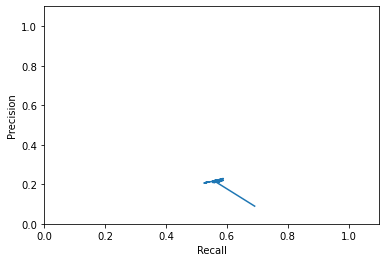

In [37]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [38]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.12229414]


### Profe:
0.00190476

### Implementacion SVM:
0.11652348

0.30308673

0.30744853

0.3115374
### CNN